In [4]:
using Pkg
Pkg.add(["Optim", "Zygote"])

   Resolving package versions...
   Installed IRTools ───────────── v0.4.15
   Installed ZygoteRules ───────── v0.2.7
   Installed RealDot ───────────── v0.1.0
   Installed SparseInverseSubset ─ v0.1.2
   Installed StructArrays ──────── v0.7.1
   Installed Zygote ────────────── v0.7.10
   Installed ChainRules ────────── v1.72.5
    Updating `~/.julia/environments/v1.11/Project.toml`
  [e88e6eb3] + Zygote v0.7.10
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [082447d4] + ChainRules v1.72.5
  [7869d1d1] + IRTools v0.4.15
  [c1ae055f] + RealDot v0.1.0
  [dc90abb0] + SparseInverseSubset v0.1.2
  [09ab397b] + StructArrays v0.7.1
  [e88e6eb3] + Zygote v0.7.10
  [700de1a5] + ZygoteRules v0.2.7
Precompiling project...
   1656.1 ms  ✓ RealDot
   1438.4 ms  ✓ SparseInverseSubset
   1739.3 ms  ✓ ZygoteRules
   1530.1 ms  ✓ StructArrays
   2797.9 ms  ✓ IRTools
    683.0 ms  ✓ StructArrays → StructArraysAdaptExt
    720.1 ms  ✓ StructArrays → StructArraysLinearAlgebraExt
    806.0 ms  

--------------------------------------------------
Theoretical SHG half-period (μm): 3.6008
Theoretical SFG half-period (μm): 0.9796
--------------------------------------------------
Initial SHG Intensity: 8.1705e-05
Starting L-BFGS optimization with Zygote (Adjoint Method)...
Fminbox
-------
Initial mu = 7.25468e-8

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 7.25468e-8

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0    -4.507019e-04     4.329245e-04
 * time: 0.033471107482910156
     1    -4.527500e-04     5.669751e-05
 * time: 1.902235984802246
     2    -5.193735e-04     7.853179e-05
 * time: 2.4296951293945312
     3    -6.091197e-04     5.418452e-05
 * time: 2.6068220138549805
     4    -6.108790e-04     5.903885e-05
 * time: 2.7790470123291016
     5    -6.950149e-04     1.297318e-04
 * time: 3.3996100425720215
     6    -7.073219e-04     1.129749e-04
 * time: 3.6675870418548584
     7    -7.611041e-04 

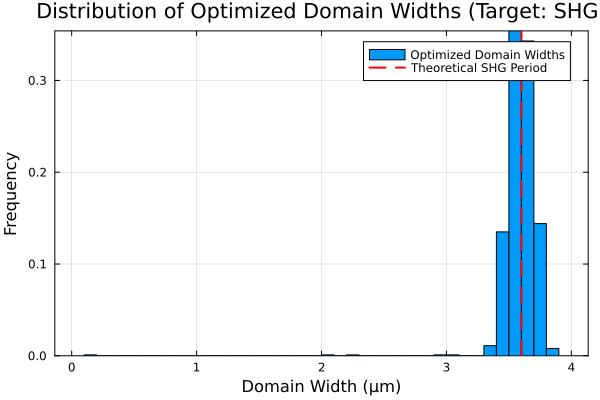

In [ ]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Printf
using Base.Threads
using Optim
using Statistics
using Zygote # Zygoteをインポート

# --- 物理パラメータと関数 (変更なし) ---
const KAPPA_MAG = 1.31e-5
const WAVELENGTH_CENTER = 1.031
const TEMP_C = 70.0
const NUM_DOMAINS = 1000 # 長さ2000というわけではないからpyの方と結果違う

const SELLMEIER_PARAMS = (
    a=[4.5615, 0.08488, 0.1927, 5.5832, 8.3067, 0.021696],
    b=[4.782e-07, 3.0913e-08, 2.7326e-08, 1.4837e-05, 1.3647e-07]
)

function sellmeier_n_eff(wl::Float64, temp::Float64)
    f = (temp - 24.5) * (temp + 24.5 + 2.0 * 273.16)
    lambda_sq = wl^2
    a, b = SELLMEIER_PARAMS.a, SELLMEIER_PARAMS.b
    n_sq = (a[1] + b[1] * f +
            (a[2] + b[2] * f) / (lambda_sq - (a[3] + b[3] * f)^2) +
            (a[4] + b[4] * f) / (lambda_sq - (a[5] + b[5] * f)^2) -
            a[6] * lambda_sq)
    return sqrt(n_sq)
end

function calculate_delta_ks(wl::Float64, temp::Float64)
    wl_fw, wl_shg = wl, wl / 2.0
    n_fw, n_shg = sellmeier_n_eff(wl_fw, temp), sellmeier_n_eff(wl_shg, temp)
    delta_k1 = 2.0 * pi * (n_shg / wl_shg - 2.0 * n_fw / wl_fw)
    wl_thg = (wl_fw * wl_shg) / (wl_fw + wl_shg)
    n_thg = sellmeier_n_eff(wl_thg, temp)
    delta_k2 = 2.0 * pi * (n_thg / wl_thg - n_shg / wl_shg - n_fw / wl_fw)
    return delta_k1, delta_k2
end

const DELTA_K1_GLOBAL, DELTA_K2_GLOBAL = calculate_delta_ks(WAVELENGTH_CENTER, TEMP_C)
const L_GLOBAL = 1im .* [0.0, DELTA_K1_GLOBAL, DELTA_K1_GLOBAL + DELTA_K2_GLOBAL]

A_from_B(B, z, delta_k1, delta_k2) = [B[1], B[2] * exp(-1im * delta_k1 * z), B[3] * exp(-1im * (delta_k1 + delta_k2) * z)]
phi(omega, h) = abs(omega) < 1e-9 ? h + h^2 * omega / 2.0 : (exp(omega * h) - 1.0) / omega

function predictor_ipm1(B_in, h, kappa_val, L)
    B1n, B2n, B3n = B_in
    L1, L2, L3 = L
    exp_Lh = exp.(L .* h)
    omega_a = L2 - 2 * L1
    omega_b = L3 - L2 - L1
    delta_B_NL1 = 1im * kappa_val * exp_Lh[1] * (conj(B1n) * B2n * phi(omega_a, h) + conj(B2n) * B3n * phi(omega_b, h))
    delta_B_NL2 = 1im * kappa_val * exp_Lh[2] * (B1n^2 * phi(-omega_a, h) + 2 * conj(B1n) * B3n * phi(omega_b, h))
    delta_B_NL3 = 1im * 3 * kappa_val * exp_Lh[3] * (B1n * B2n * phi(-omega_b, h))
    return (exp_Lh .* B_in) + [delta_B_NL1, delta_B_NL2, delta_B_NL3]
end

# Zygoteが勾配を計算できるように、シミュレーション関数を修正
# グローバル定数へのアクセスを避け、引数として渡すようにする
function run_simulation(domain_widths::Vector{Float64}, K_M, L, D_K1, D_K2)
    B = ComplexF64[1.0, 0.0, 0.0]
    kappa_sign = 1.0

    for h in domain_widths
        B = predictor_ipm1(B, h, K_M * kappa_sign, L)
        kappa_sign *= -1.0
    end

    z_final = sum(domain_widths)
    A_final = A_from_B(B, z_final, D_K1, D_K2)
    return abs2(A_final[2]) # SHG強度を返す
end

# 目的関数
objective(domain_widths) = -run_simulation(domain_widths, KAPPA_MAG, L_GLOBAL, DELTA_K1_GLOBAL, DELTA_K2_GLOBAL)

# --- メイン実行部 ---
function main()
    # 理論周期の計算
    shg_period = pi / DELTA_K1_GLOBAL
    sfg_period = pi / DELTA_K2_GLOBAL
    println("-"^50)
    @printf "Theoretical SHG half-period (μm): %.4f\n" shg_period
    @printf "Theoretical SFG half-period (μm): %.4f\n" sfg_period
    println("-"^50)

    # --- 最適化の初期設定 ---
    # ★変更点: 最適化が機能するように、SHG周期にノイズを加えたものからスタート
    initial_widths = fill(shg_period, NUM_DOMAINS)
    initial_widths .*= (1.0 .+ 0.2 .* (rand(NUM_DOMAINS) .- 0.5))

    lower_bounds = fill(0.1, NUM_DOMAINS)
    upper_bounds = fill(50.0, NUM_DOMAINS)

    # --- Zygoteによる勾配関数の定義 ---
    # Zygote.gradientは(値, 勾配)のタプルを返すことがあるので、[1]で勾配のみ取り出す
    # 目的関数 objective を domain_widths で微分する
    grad_func! = (g, w) -> (g .= Zygote.gradient(objective, w)[1])

    initial_shg_intensity = run_simulation(initial_widths, KAPPA_MAG, L_GLOBAL, DELTA_K1_GLOBAL, DELTA_K2_GLOBAL)
    @printf "Initial SHG Intensity: %.4e\n" initial_shg_intensity
    println("Starting L-BFGS optimization with Zygote (Adjoint Method)...")

    # --- 最適化の実行 ---
    optimizer = Fminbox(LBFGS())
    options = Optim.Options(show_trace=true, iterations=100, g_tol=1e-8)

    # ★変更点: 自作の勾配関数の代わりにZygoteで生成したgrad_func!を渡す
    @time result = optimize(objective, grad_func!, lower_bounds, upper_bounds, initial_widths, optimizer, options)

    # --- 結果の表示 ---
    println("\nOptimization finished.")
    println("-"^50)
    println(Optim.summary(result))
    println("-"^50)

    optimized_widths = Optim.minimizer(result)
    final_shg_intensity = -Optim.minimum(result)

    @printf "Initial SHG Intensity : %.4e\n" initial_shg_intensity
    @printf "Final SHG Intensity   : %.4e\n" final_shg_intensity
    # 理想的なQPM構造の理論効率は length^2 に比例する
    ideal_intensity = run_simulation(fill(shg_period, NUM_DOMAINS), KAPPA_MAG, L_GLOBAL, DELTA_K1_GLOBAL, DELTA_K2_GLOBAL)
    @printf "Ideal Periodic Intensity: %.4e (%.2f%% of ideal)\n" ideal_intensity (final_shg_intensity / ideal_intensity * 100)

    mean_width = mean(optimized_widths)
    std_width = std(optimized_widths)
    @printf "Mean of optimized widths: %.4f μm (Theoretical SHG period: %.4f μm)\n" mean_width shg_period
    @printf "Std. Dev of widths      : %.4f μm\n" std_width

    # --- 結果の可視化 ---
    p = histogram(optimized_widths, bins=50, normalize=:probability,
        label="Optimized Domain Widths",
        xlabel="Domain Width (μm)",
        ylabel="Frequency",
        title="Distribution of Optimized Domain Widths (Target: SHG)",
        legend=:topright, framestyle=:box)
    vline!([shg_period], label="Theoretical SHG Period", color=:red, linestyle=:dash, linewidth=2)
    display(p)
end

main()